In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="sociologymodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [8]:
sociologyFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [9]:
sociologyFOSID = sociologyFOSID.filter(sociologyFOSID["Domain"]=="Sociology").collect()

In [10]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [11]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [12]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [13]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(sociologyFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [14]:
fos.show(2)

+--------+---------+
|  FOS_ID|   Domain|
+--------+---------+
|24667770|Sociology|
|36289849|Sociology|
+--------+---------+
only showing top 2 rows



In [15]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [16]:
papers_filtered.count()

7609703

In [17]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [18]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [19]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [27]:
(sample1,sample2) = papers_filtered1.randomSplit([0.09,0.5])

In [28]:
sample1.count()

1161261

In [29]:
from sklearn import model_selection
from sklearn.model_selection import KFold

In [30]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             0|
|             0|
|             0|
|             0|
+--------------+
only showing top 4 rows



In [31]:
sample1_pd = sample1.toPandas()

In [32]:
import numpy as np

In [33]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [34]:
from sklearn import metrics

In [35]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 2.321830320660041)
('Mean Squared Error of EstimatedCount:', 5698.641732564858)
('Root Mean Squared of with EstimatedCount:', 75.48934847092573)


In [36]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [37]:
sample1_pd.shape

(1161261, 12)

In [38]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [39]:
from sklearn.model_selection import KFold

In [40]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 1.6566836384582513)
('Mean Squared Error:', 226.19797413417703)
('Root Mean Squared Error:', 15.039879458764855)
('Mean Absolute Error:', 1.2008485417478654)
('Mean Squared Error:', 115.72705828623891)
('Root Mean Squared Error:', 10.757651150982676)
('Mean Absolute Error:', 2.725717519631336)
('Mean Squared Error:', 2339.1999550135297)
('Root Mean Squared Error:', 48.365276335543975)
('Mean Absolute Error:', 2.03822497899277)
('Mean Squared Error:', 639.33629740551)
('Root Mean Squared Error:', 25.285100304438384)
('Mean Absolute Error:', 0.7495968761199996)
('Mean Squared Error:', 570.5711203007362)
('Root Mean Squared Error:', 23.886630576553408)


In [43]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 24.66690756525666)


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
featureslist=sample1_pd.columns

In [46]:
importances = regressor.feature_importances_

In [47]:
import pandas as pd

In [48]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.62676
Feature: 1, Score: 0.01115
Feature: 2, Score: 0.27903
Feature: 3, Score: 0.00235
Feature: 4, Score: 0.00842
Feature: 5, Score: 0.01264
Feature: 6, Score: 0.00600
Feature: 7, Score: 0.01457
Feature: 8, Score: 0.02874
Feature: 9, Score: 0.00597
Feature: 10, Score: 0.00437


## XGBoost Regression model

In [49]:
import xgboost as xgb

In [50]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [51]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
   # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error of XGBoost Kfold:', 1.7361924149771961)
('Mean Squared Error of XGBoost Kfold:', 321.7522005786695)
('Root Mean Squared Error of XGBoost Kfold:', 17.937452455091538)
('Mean Absolute Error of XGBoost Kfold:', 1.2551482307221948)
('Mean Squared Error of XGBoost Kfold:', 132.21453035490288)
('Root Mean Squared Error of XGBoost Kfold:', 11.498457738101353)
('Mean Absolute Error of XGBoost Kfold:', 2.9192981926691175)
('Mean Squared Error of XGBoost Kfold:', 2603.875964005259)
('Root Mean Squared Error of XGBoost Kfold:', 51.02818793574057)
('Mean Absolute Error of XGBoost Kfold:', 2.1252180171605866)
('Mean Squared Error of XGBoost Kfold:', 627.6022456462018)
('Root Mean Squared Error of XGBoost Kfold:', 25.051990851950308)
('Mean Absolute Error of XGBoost Kfold:', 0.7476966204520299)
('Mean Squared Error of XGBoost Kfold:', 401.322632815465)
('Root Mean Squared Error of XGBoost Kfold:', 20.033038531772085)


In [52]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 25.10982550253117)


In [53]:
importances = regressor.feature_importances_

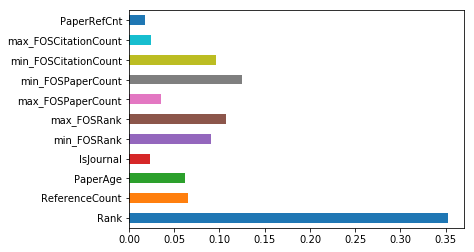

In [54]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [55]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.35229
Feature: 1, Score: 0.06545
Feature: 2, Score: 0.06232
Feature: 3, Score: 0.02309
Feature: 4, Score: 0.09034
Feature: 5, Score: 0.10763
Feature: 6, Score: 0.03497
Feature: 7, Score: 0.12514
Feature: 8, Score: 0.09638
Feature: 9, Score: 0.02461
Feature: 10, Score: 0.01777
